In [1]:
import warnings
import numpy as np
from PIL import Image, ImageDraw
from utils.preprocess import load_and_flip_odds, crop_black_edge, adaptive_median_filter, CLAHE, edge_detection, line_detection, remove_pm, aug, get_label_dict
from utils.train import train

warnings.filterwarnings('ignore')

# 1. Image Preprocessing

## 1.1 Cut black blocks on left and right sides

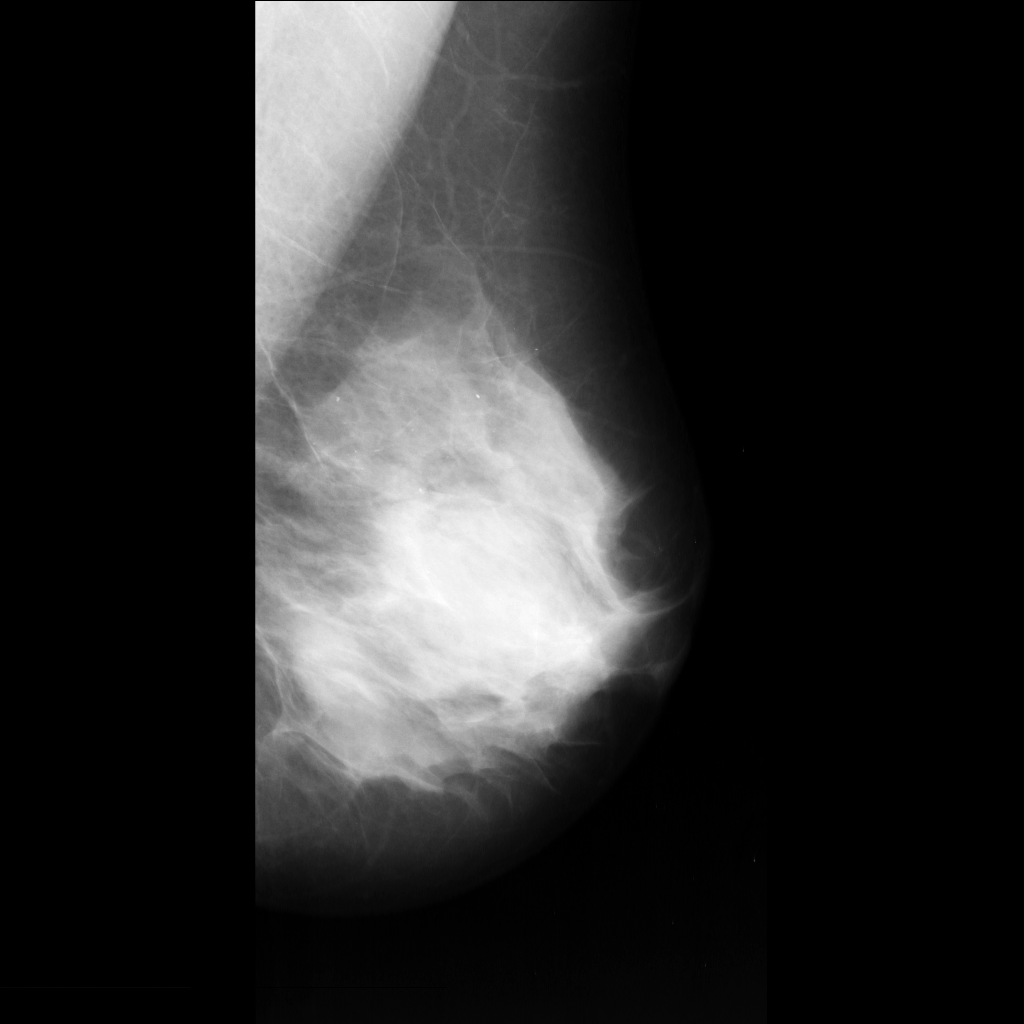

In [2]:
img_dict = load_and_flip_odds('Dataset/MIAS') # for convenience in later processing, we first flip all odds imgs
Image.fromarray(img_dict['mdb001']) # display mdb001 img as example

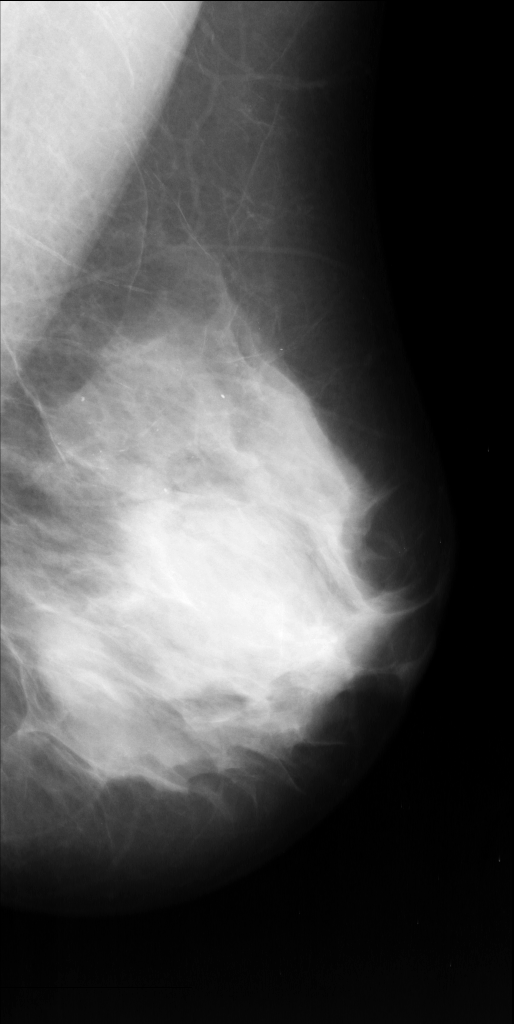

In [3]:
crop_img_dict = crop_black_edge(img_dict)
Image.fromarray(crop_img_dict['mdb001'])

## 1.2 Apply adaptive median filter to remove salt-and-pepper noise

Salt-and-pepper noise shows up as pixels with extreme values: 0 (black) or 255 (white) in an 8-bit grayscale image.

The basic idea of adaptive median filter is:

1. Identify noisy pixels (0 or 255).
2. Replace them using a median of surrounding non-noisy pixels.
3. Adaptively increase the size of the neighborhood if no non-noisy pixels are found.

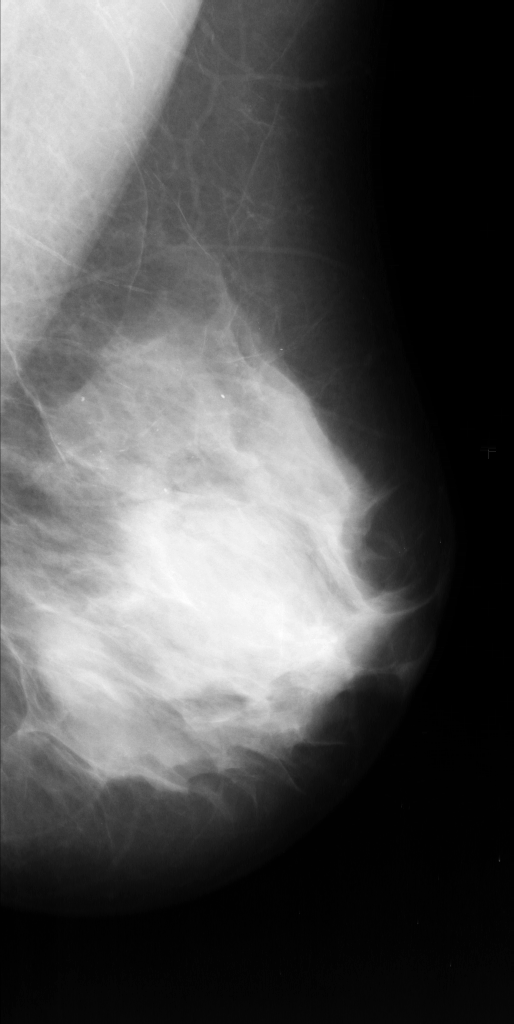

In [4]:
filter_img_dict = adaptive_median_filter(crop_img_dict)
Image.fromarray(filter_img_dict['mdb001'])

## 1.3 Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to brighten the details
Histogram Equalization (HE) is stretching the brightness range for the whole image.

Problem with normal HE: if different parts of the image need different adjustments, some regions may look bad.

Solution: Adaptive Histogram Equalization (AHE):
1. Cut the image into small blocks.
2. Apply HE to each block separately. (cv2 will blend the boundary of blocks by bilinear interpolation)

Problem with AHE: Sometimes one brightness value is too common in a block. Normal AHE would stretch this, and tiny random differences in pixels would blow up into "grainy noise".

Solution: Contrast Limited Adaptive Histogram Equalization(CLAHE): Same as AHE, but limits how much contrast can be stretched in each block. This prevents noise from being boosted too much.

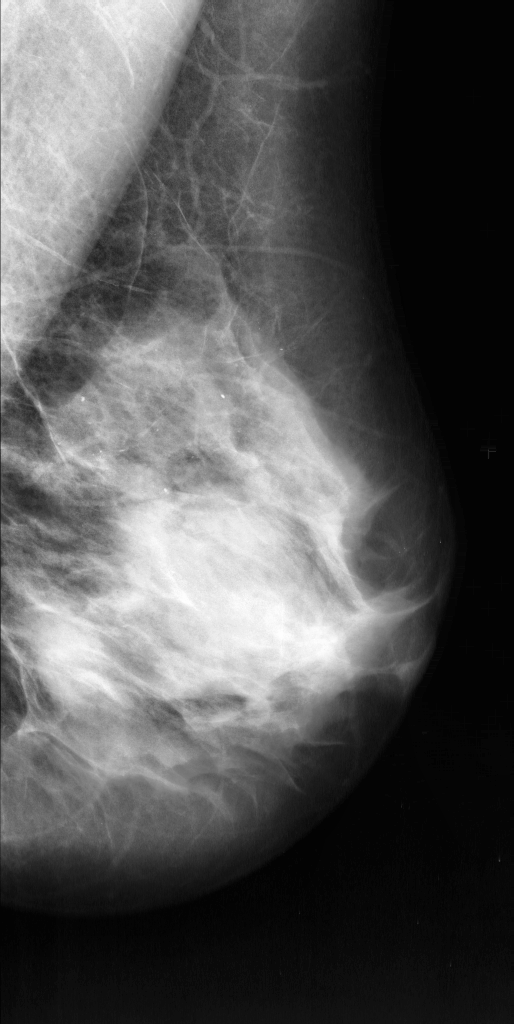

In [5]:
clahe_img_dict = CLAHE(filter_img_dict)
Image.fromarray(clahe_img_dict['mdb001'])

## 1.4 Apply canny edge detection with sober filter to get the raw boundaries of tissues

The basic idea of canny edge detection is:

1. Checking for sudden changes in brightness - If brightness jumps quickly, that's an edge.
2. The sober filter calculates how much brightness change left to right (horizontal gradient), up to down (vertical gradient), so to know where edges are, and how strong they are.
3. After sober filter, set threshold to discard weak gradient and keep strong gradient, and middle gradient is only kept if they are connected to strong edge (otherwise might be noise, shall discard). This is called edge tracking by hysteresis.

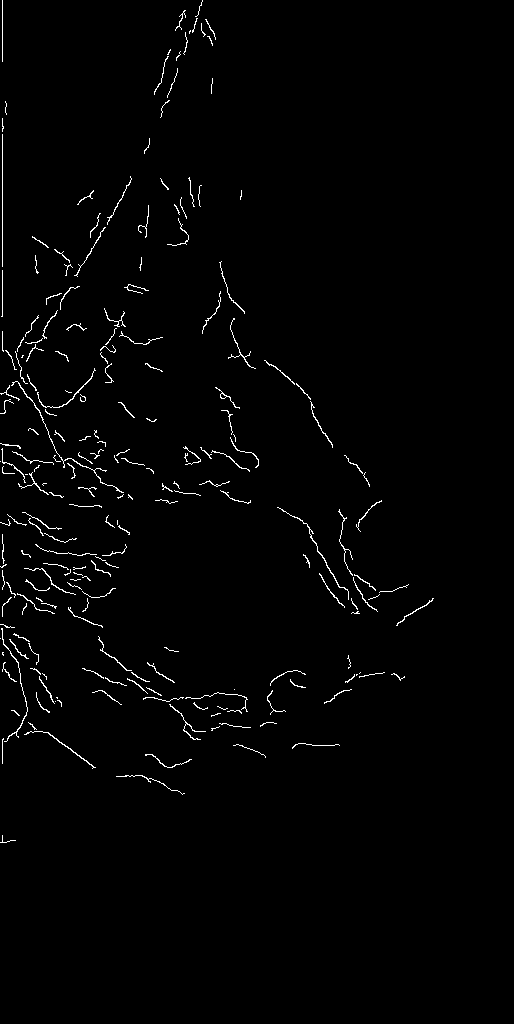

In [6]:
edge_dict = edge_detection(clahe_img_dict)
Image.fromarray(edge_dict['mdb001'])

## 1.5 Apply Hough Transform with customized criteria to get the seperate line of PM (pectoral muscle) and breast tissue

The basic idea of Hough Transformation is:

For any line of origin (ρ) and angle (θ) in Hough space, when many pixels are on the line (or not far off the line), the line is considered real in the img.

Detected lines are then filtered based on 1. customized geometric constraints (angle and distance to upper left corner); 2. when removed, the minimal info loss (otherwise, the line might be on the PM or on the breast tissue as the two regions have many info).

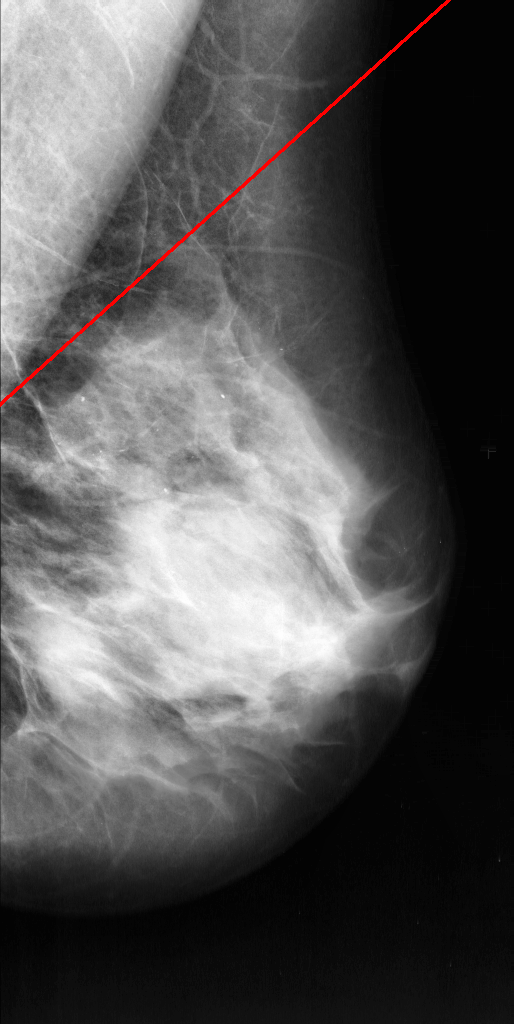

In [7]:
line_dict = line_detection(edge_dict, clahe_img_dict)

# Below is just for display: add the line to mdb001 as red
clahe_img_rgb = np.stack([clahe_img_dict['mdb001']]*3, axis=-1)
img_pil = Image.fromarray(clahe_img_rgb)
draw = ImageDraw.Draw(img_pil)

x1, y1, x2, y2 = line_dict['mdb001']
draw.line((x1, y1, x2, y2), fill=(255, 0, 0), width=3)
display(img_pil)

## 1.6 Remove the PM part along the detected line

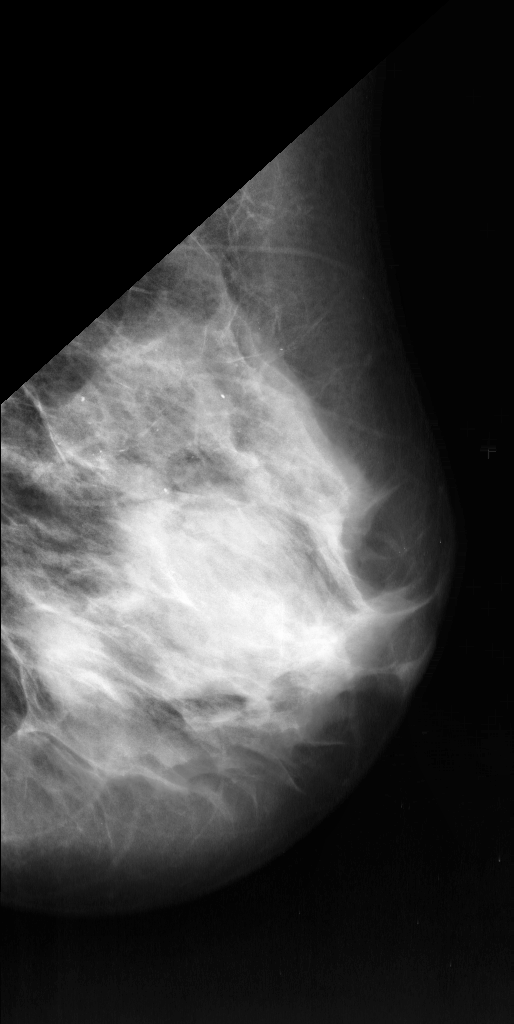

In [8]:
nopm_img_dict = remove_pm(line_dict, clahe_img_dict)
Image.fromarray(nopm_img_dict['mdb001'])

## 1.7 Offline data augmentation: randomly rotate and flip

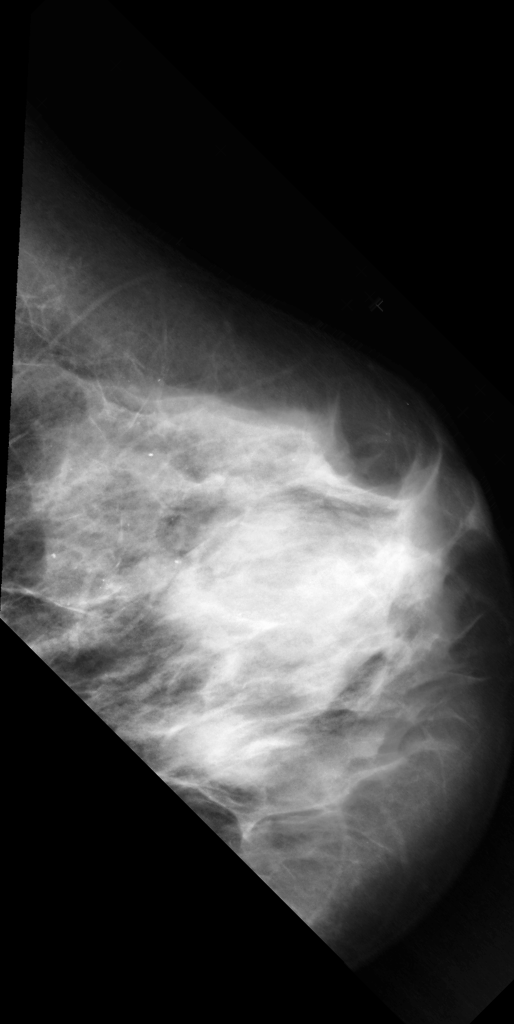

In [9]:
aug_img_dict = aug(nopm_img_dict)
Image.fromarray(aug_img_dict['mdb001_45']) # this is the 45-degree rotation of mdb001 img

# 2 Modelling
A hybrid CNN ensemble model that integrates VGG16, VGG19, ResNet50, and DenseNet121 with selective fine-tuning, feature extraction, feature reduction (via custom fully connected layers), and early fusion for classification is used.

The architecture is as follows:
```
Hybrid CNN
├── VGG16 (pretrained, fine-tuned from block4_conv3 → block5)
│    └── Features → Flatten (25088) → FC (25088 → 1024) → ReLU
│
├── VGG19 (pretrained, fine-tuned from block4_pool → block5)
│    └── Features → Flatten (25088) → FC (25088 → 1024) → ReLU
│
├── ResNet50 (pretrained, fine-tuned on layer3 & layer4)
│    └── Features → GAP → FC (2048 → 1024) → ReLU
│
└── DenseNet121 (pretrained, fine-tuned on denseblock3 & denseblock4)
|    └── Features → GAP → FC (1024 → 1024) → ReLU
↓
Fusion Network
 ├── Concatenate (4×1024 = 4096)
 ├── Dropout(0.6)
 ├── BatchNorm1d(4096)
 └── Linear(4096 → 3 classes)
```

See `utils/models.py` for more detailed info.

# 3 Train
Train in multiple epoches with mini-batches.

As the dataset is still relatively small after offline augmentation, we operate in 5-fold train-val and check the average performance of all folds to have a more general understanding of the model's performance. The model with the best overall val acc in each fold is chosen for the final performance averaging.

In each fold, the confusion matrix (Malignant, Benign, Normal) of the model after the last epoch, the train-val loss by epoch, the train-val acc by epoch are also printed out for monitoring.

Use device: cuda

Fold 1/5


Epoch 1/15: 100%|██████████| 65/65 [00:40<00:00,  1.61it/s]


Epoch 1/15:
Train Loss: 1.3711, Train Acc: 0.3625
Val Loss: 1.5955, Val Acc: 0.4894


Epoch 2/15: 100%|██████████| 65/65 [00:39<00:00,  1.63it/s]


Epoch 2/15:
Train Loss: 1.1391, Train Acc: 0.4582
Val Loss: 1.2082, Val Acc: 0.4261


Epoch 3/15: 100%|██████████| 65/65 [00:39<00:00,  1.64it/s]


Epoch 3/15:
Train Loss: 0.9245, Train Acc: 0.5894
Val Loss: 0.8146, Val Acc: 0.6142


Epoch 4/15: 100%|██████████| 65/65 [00:39<00:00,  1.65it/s]


Epoch 4/15:
Train Loss: 0.6517, Train Acc: 0.7216
Val Loss: 0.9666, Val Acc: 0.5912


Epoch 5/15: 100%|██████████| 65/65 [00:39<00:00,  1.64it/s]


Epoch 5/15:
Train Loss: 0.4911, Train Acc: 0.8034
Val Loss: 0.6725, Val Acc: 0.7274


Epoch 6/15: 100%|██████████| 65/65 [00:39<00:00,  1.63it/s]


Epoch 6/15:
Train Loss: 0.3514, Train Acc: 0.8625
Val Loss: 0.9258, Val Acc: 0.6679


Epoch 7/15: 100%|██████████| 65/65 [00:39<00:00,  1.63it/s]


Epoch 7/15:
Train Loss: 0.2822, Train Acc: 0.8990
Val Loss: 0.7121, Val Acc: 0.7198


Epoch 8/15: 100%|██████████| 65/65 [00:40<00:00,  1.62it/s]


Epoch 8/15:
Train Loss: 0.1943, Train Acc: 0.9322
Val Loss: 0.8140, Val Acc: 0.7370


Epoch 9/15: 100%|██████████| 65/65 [00:39<00:00,  1.63it/s]


Epoch 9/15:
Train Loss: 0.1630, Train Acc: 0.9428
Val Loss: 0.7369, Val Acc: 0.7409


Epoch 10/15: 100%|██████████| 65/65 [00:40<00:00,  1.62it/s]


Epoch 10/15:
Train Loss: 0.1596, Train Acc: 0.9471
Val Loss: 1.5537, Val Acc: 0.7946


Epoch 11/15: 100%|██████████| 65/65 [00:40<00:00,  1.61it/s]


Epoch 11/15:
Train Loss: 0.0773, Train Acc: 0.9788
Val Loss: 0.4970, Val Acc: 0.8138


Epoch 12/15: 100%|██████████| 65/65 [00:39<00:00,  1.64it/s]


Epoch 12/15:
Train Loss: 0.0438, Train Acc: 0.9904
Val Loss: 0.4747, Val Acc: 0.8330


Epoch 13/15: 100%|██████████| 65/65 [00:40<00:00,  1.60it/s]


Epoch 13/15:
Train Loss: 0.0382, Train Acc: 0.9899
Val Loss: 0.4539, Val Acc: 0.8273


Epoch 14/15: 100%|██████████| 65/65 [00:40<00:00,  1.60it/s]


Epoch 14/15:
Train Loss: 0.0319, Train Acc: 0.9928
Val Loss: 0.4899, Val Acc: 0.8253


Epoch 15/15: 100%|██████████| 65/65 [00:39<00:00,  1.64it/s]


Epoch 15/15:
Train Loss: 0.0286, Train Acc: 0.9933
Val Loss: 0.4682, Val Acc: 0.8157


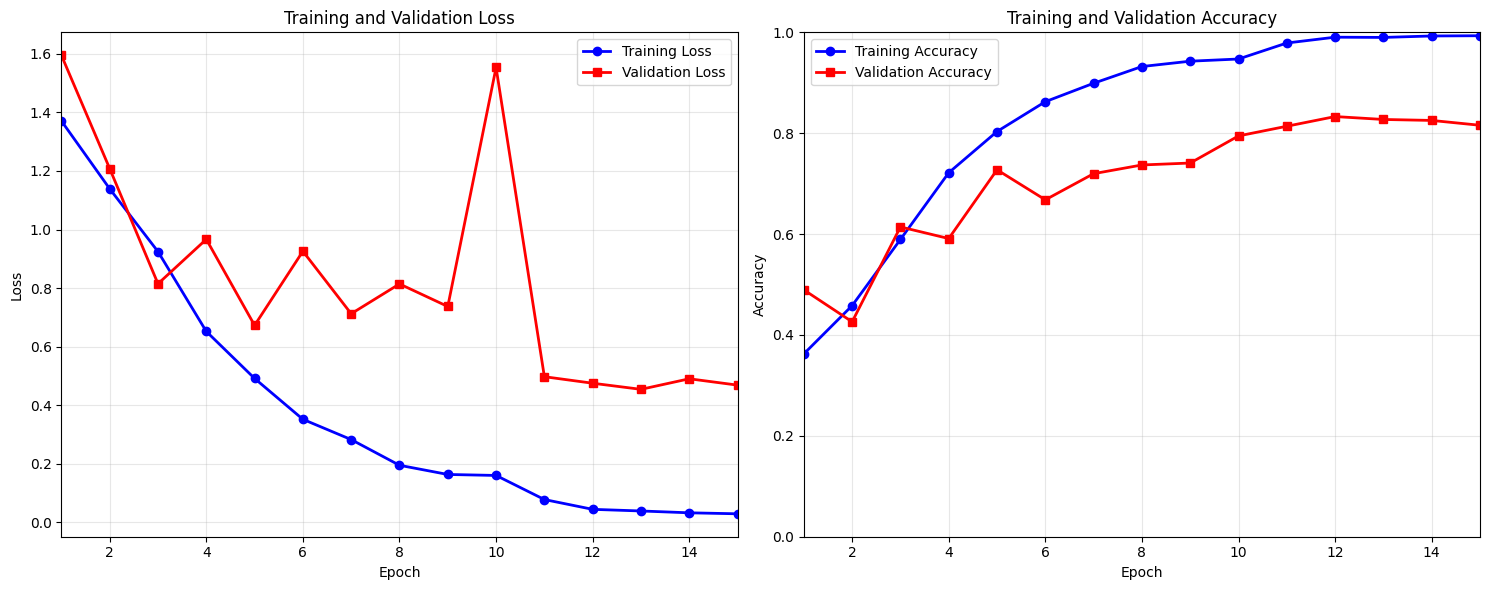

Fold 1 Test Accuracy: 0.8157
Fold 1 Confusion Matrix:
[[ 53   4  24]
 [  1  66  40]
 [ 10  17 306]]

Fold 2/5


Epoch 1/15: 100%|██████████| 65/65 [00:40<00:00,  1.61it/s]


Epoch 1/15:
Train Loss: 1.3390, Train Acc: 0.4120
Val Loss: 1.4592, Val Acc: 0.3077


Epoch 2/15: 100%|██████████| 65/65 [00:50<00:00,  1.29it/s]


Epoch 2/15:
Train Loss: 1.0372, Train Acc: 0.5341
Val Loss: 1.1008, Val Acc: 0.6250


Epoch 3/15: 100%|██████████| 65/65 [00:47<00:00,  1.37it/s]


Epoch 3/15:
Train Loss: 0.8380, Train Acc: 0.6514
Val Loss: 1.1862, Val Acc: 0.5327


Epoch 4/15: 100%|██████████| 65/65 [00:49<00:00,  1.32it/s]


Epoch 4/15:
Train Loss: 0.5183, Train Acc: 0.7846
Val Loss: 0.8880, Val Acc: 0.6500


Epoch 5/15: 100%|██████████| 65/65 [00:51<00:00,  1.27it/s]


Epoch 5/15:
Train Loss: 0.4175, Train Acc: 0.8385
Val Loss: 1.1340, Val Acc: 0.6615


Epoch 6/15: 100%|██████████| 65/65 [00:51<00:00,  1.27it/s]


Epoch 6/15:
Train Loss: 0.3236, Train Acc: 0.8803
Val Loss: 1.5002, Val Acc: 0.6019


Epoch 7/15: 100%|██████████| 65/65 [00:52<00:00,  1.25it/s]


Epoch 7/15:
Train Loss: 0.2836, Train Acc: 0.8923
Val Loss: 0.9272, Val Acc: 0.7327


Epoch 8/15: 100%|██████████| 65/65 [00:49<00:00,  1.31it/s]


Epoch 8/15:
Train Loss: 0.2032, Train Acc: 0.9264
Val Loss: 1.1267, Val Acc: 0.7058


Epoch 9/15: 100%|██████████| 65/65 [00:52<00:00,  1.24it/s]


Epoch 9/15:
Train Loss: 0.1643, Train Acc: 0.9442
Val Loss: 1.5739, Val Acc: 0.7212


Epoch 10/15: 100%|██████████| 65/65 [00:50<00:00,  1.29it/s]


Epoch 10/15:
Train Loss: 0.1457, Train Acc: 0.9471
Val Loss: 0.8342, Val Acc: 0.7519


Epoch 11/15: 100%|██████████| 65/65 [00:47<00:00,  1.37it/s]


Epoch 11/15:
Train Loss: 0.1095, Train Acc: 0.9587
Val Loss: 0.5779, Val Acc: 0.8212


Epoch 12/15: 100%|██████████| 65/65 [00:47<00:00,  1.37it/s]


Epoch 12/15:
Train Loss: 0.0554, Train Acc: 0.9832
Val Loss: 0.5518, Val Acc: 0.8269


Epoch 13/15: 100%|██████████| 65/65 [00:47<00:00,  1.37it/s]


Epoch 13/15:
Train Loss: 0.0376, Train Acc: 0.9894
Val Loss: 0.5541, Val Acc: 0.8269


Epoch 14/15: 100%|██████████| 65/65 [00:47<00:00,  1.37it/s]


Epoch 14/15:
Train Loss: 0.0287, Train Acc: 0.9928
Val Loss: 0.5598, Val Acc: 0.8269


Epoch 15/15: 100%|██████████| 65/65 [00:47<00:00,  1.37it/s]


Epoch 15/15:
Train Loss: 0.0220, Train Acc: 0.9942
Val Loss: 0.5641, Val Acc: 0.8288


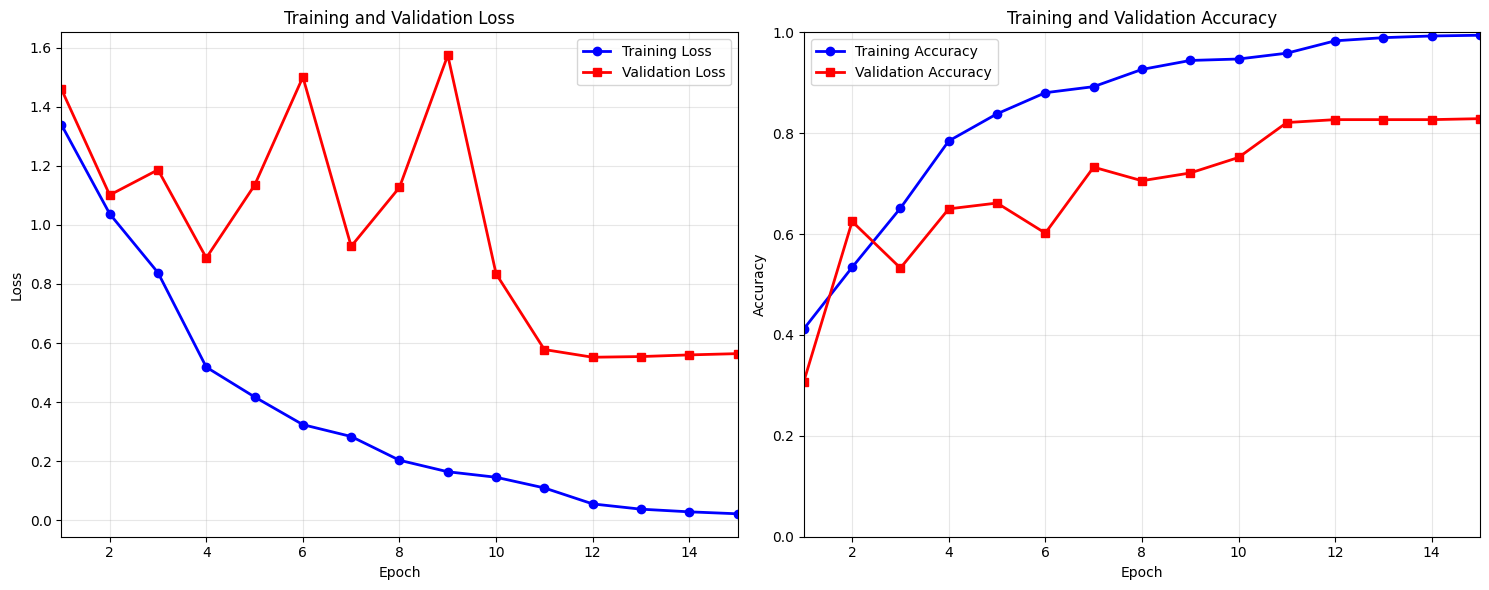

Fold 2 Test Accuracy: 0.8288
Fold 2 Confusion Matrix:
[[ 48   8  25]
 [  2  62  42]
 [  3   9 321]]

Fold 3/5


Epoch 1/15: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch 1/15:
Train Loss: 1.3010, Train Acc: 0.4058
Val Loss: 6.0717, Val Acc: 0.2712


Epoch 2/15: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch 2/15:
Train Loss: 1.0688, Train Acc: 0.5168
Val Loss: 2.2904, Val Acc: 0.4000


Epoch 3/15: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch 3/15:
Train Loss: 0.7986, Train Acc: 0.6495
Val Loss: 1.5723, Val Acc: 0.4462


Epoch 4/15: 100%|██████████| 65/65 [00:48<00:00,  1.34it/s]


Epoch 4/15:
Train Loss: 0.5491, Train Acc: 0.7769
Val Loss: 0.8451, Val Acc: 0.6865


Epoch 5/15: 100%|██████████| 65/65 [00:47<00:00,  1.36it/s]


Epoch 5/15:
Train Loss: 0.4477, Train Acc: 0.8240
Val Loss: 0.8294, Val Acc: 0.6981


Epoch 6/15: 100%|██████████| 65/65 [00:48<00:00,  1.35it/s]


Epoch 6/15:
Train Loss: 0.3745, Train Acc: 0.8615
Val Loss: 0.8945, Val Acc: 0.6750


Epoch 7/15: 100%|██████████| 65/65 [00:47<00:00,  1.36it/s]


Epoch 7/15:
Train Loss: 0.2318, Train Acc: 0.9159
Val Loss: 0.8682, Val Acc: 0.7327


Epoch 8/15: 100%|██████████| 65/65 [01:03<00:00,  1.02it/s]


Epoch 8/15:
Train Loss: 0.1681, Train Acc: 0.9423
Val Loss: 1.1155, Val Acc: 0.7288


Epoch 9/15: 100%|██████████| 65/65 [01:05<00:00,  1.00s/it]


Epoch 9/15:
Train Loss: 0.1424, Train Acc: 0.9514
Val Loss: 0.8472, Val Acc: 0.7538


Epoch 10/15: 100%|██████████| 65/65 [01:06<00:00,  1.02s/it]


Epoch 10/15:
Train Loss: 0.1420, Train Acc: 0.9471
Val Loss: 1.0613, Val Acc: 0.7692


Epoch 11/15: 100%|██████████| 65/65 [01:05<00:00,  1.01s/it]


Epoch 11/15:
Train Loss: 0.0715, Train Acc: 0.9793
Val Loss: 0.7422, Val Acc: 0.7885


Epoch 12/15: 100%|██████████| 65/65 [01:05<00:00,  1.01s/it]


Epoch 12/15:
Train Loss: 0.0397, Train Acc: 0.9875
Val Loss: 0.7052, Val Acc: 0.8096


Epoch 13/15: 100%|██████████| 65/65 [01:05<00:00,  1.00s/it]


Epoch 13/15:
Train Loss: 0.0382, Train Acc: 0.9875
Val Loss: 0.6318, Val Acc: 0.8154


Epoch 14/15: 100%|██████████| 65/65 [01:04<00:00,  1.01it/s]


Epoch 14/15:
Train Loss: 0.0287, Train Acc: 0.9923
Val Loss: 0.5963, Val Acc: 0.8173


Epoch 15/15: 100%|██████████| 65/65 [01:04<00:00,  1.00it/s]


Epoch 15/15:
Train Loss: 0.0194, Train Acc: 0.9966
Val Loss: 0.5726, Val Acc: 0.8231


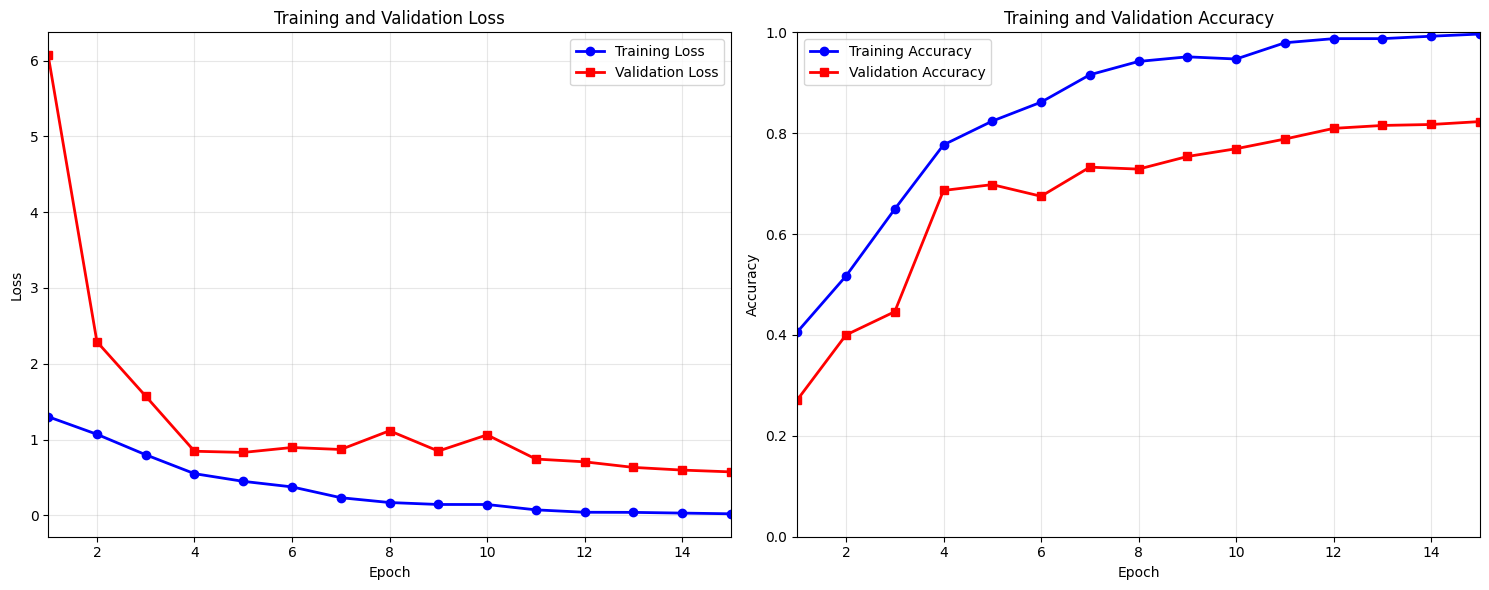

Fold 3 Test Accuracy: 0.8231
Fold 3 Confusion Matrix:
[[ 53   5  23]
 [  5  58  43]
 [  3  13 317]]

Fold 4/5


Epoch 1/15: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


Epoch 1/15:
Train Loss: 1.3326, Train Acc: 0.3851
Val Loss: 2.2246, Val Acc: 0.5038


Epoch 2/15: 100%|██████████| 65/65 [01:07<00:00,  1.04s/it]


Epoch 2/15:
Train Loss: 1.0415, Train Acc: 0.5337
Val Loss: 0.9416, Val Acc: 0.6192


Epoch 3/15: 100%|██████████| 65/65 [01:06<00:00,  1.03s/it]


Epoch 3/15:
Train Loss: 0.7274, Train Acc: 0.7000
Val Loss: 0.8991, Val Acc: 0.6192


Epoch 4/15: 100%|██████████| 65/65 [01:06<00:00,  1.02s/it]


Epoch 4/15:
Train Loss: 0.5168, Train Acc: 0.7933
Val Loss: 0.6968, Val Acc: 0.7250


Epoch 5/15: 100%|██████████| 65/65 [01:06<00:00,  1.02s/it]


Epoch 5/15:
Train Loss: 0.3991, Train Acc: 0.8490
Val Loss: 0.6988, Val Acc: 0.7288


Epoch 6/15: 100%|██████████| 65/65 [01:06<00:00,  1.02s/it]


Epoch 6/15:
Train Loss: 0.2837, Train Acc: 0.8962
Val Loss: 0.7757, Val Acc: 0.7115


Epoch 7/15: 100%|██████████| 65/65 [01:07<00:00,  1.03s/it]


Epoch 7/15:
Train Loss: 0.2264, Train Acc: 0.9173
Val Loss: 0.7938, Val Acc: 0.7365


Epoch 8/15: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


Epoch 8/15:
Train Loss: 0.1533, Train Acc: 0.9433
Val Loss: 0.8178, Val Acc: 0.7327


Epoch 9/15: 100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


Epoch 9/15:
Train Loss: 0.0947, Train Acc: 0.9659
Val Loss: 0.7196, Val Acc: 0.8000


Epoch 10/15: 100%|██████████| 65/65 [01:07<00:00,  1.04s/it]


Epoch 10/15:
Train Loss: 0.1438, Train Acc: 0.9500
Val Loss: 0.8910, Val Acc: 0.7481


Epoch 11/15: 100%|██████████| 65/65 [01:07<00:00,  1.04s/it]


Epoch 11/15:
Train Loss: 0.0768, Train Acc: 0.9784
Val Loss: 0.5495, Val Acc: 0.8115


Epoch 12/15: 100%|██████████| 65/65 [01:06<00:00,  1.03s/it]


Epoch 12/15:
Train Loss: 0.0437, Train Acc: 0.9865
Val Loss: 0.5079, Val Acc: 0.8250


Epoch 13/15: 100%|██████████| 65/65 [01:05<00:00,  1.01s/it]


Epoch 13/15:
Train Loss: 0.0240, Train Acc: 0.9966
Val Loss: 0.5050, Val Acc: 0.8269


Epoch 14/15: 100%|██████████| 65/65 [01:07<00:00,  1.03s/it]


Epoch 14/15:
Train Loss: 0.0196, Train Acc: 0.9971
Val Loss: 0.5079, Val Acc: 0.8288


Epoch 15/15: 100%|██████████| 65/65 [01:06<00:00,  1.02s/it]


Epoch 15/15:
Train Loss: 0.0169, Train Acc: 0.9976
Val Loss: 0.5604, Val Acc: 0.8250


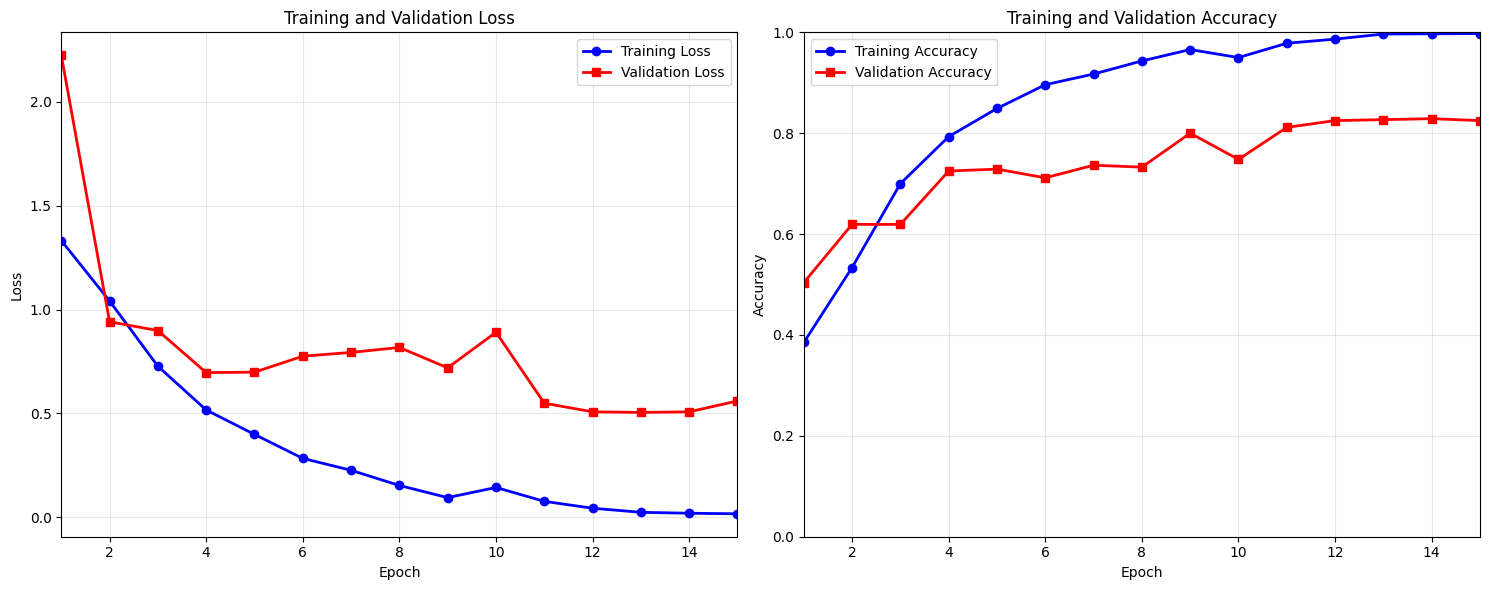

Fold 4 Test Accuracy: 0.8250
Fold 4 Confusion Matrix:
[[ 59   2  20]
 [  5  53  48]
 [  7   9 317]]

Fold 5/5


Epoch 1/15: 100%|██████████| 65/65 [01:07<00:00,  1.03s/it]


Epoch 1/15:
Train Loss: 1.3711, Train Acc: 0.3981
Val Loss: 1.0074, Val Acc: 0.5250


Epoch 2/15: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


Epoch 2/15:
Train Loss: 1.0797, Train Acc: 0.5072
Val Loss: 1.1207, Val Acc: 0.4808


Epoch 3/15: 100%|██████████| 65/65 [01:07<00:00,  1.04s/it]


Epoch 3/15:
Train Loss: 0.7730, Train Acc: 0.6654
Val Loss: 0.8569, Val Acc: 0.6846


Epoch 4/15: 100%|██████████| 65/65 [01:08<00:00,  1.05s/it]


Epoch 4/15:
Train Loss: 0.5436, Train Acc: 0.7731
Val Loss: 0.9928, Val Acc: 0.5808


Epoch 5/15: 100%|██████████| 65/65 [01:05<00:00,  1.01s/it]


Epoch 5/15:
Train Loss: 0.3767, Train Acc: 0.8514
Val Loss: 0.8168, Val Acc: 0.7192


Epoch 6/15: 100%|██████████| 65/65 [01:07<00:00,  1.04s/it]


Epoch 6/15:
Train Loss: 0.2819, Train Acc: 0.9000
Val Loss: 0.8551, Val Acc: 0.7038


Epoch 7/15: 100%|██████████| 65/65 [01:06<00:00,  1.03s/it]


Epoch 7/15:
Train Loss: 0.2085, Train Acc: 0.9269
Val Loss: 0.7611, Val Acc: 0.7404


Epoch 8/15: 100%|██████████| 65/65 [01:07<00:00,  1.03s/it]


Epoch 8/15:
Train Loss: 0.1859, Train Acc: 0.9341
Val Loss: 1.1312, Val Acc: 0.6788


Epoch 9/15: 100%|██████████| 65/65 [01:06<00:00,  1.02s/it]


Epoch 9/15:
Train Loss: 0.1619, Train Acc: 0.9442
Val Loss: 0.8489, Val Acc: 0.7423


Epoch 10/15: 100%|██████████| 65/65 [01:06<00:00,  1.02s/it]


Epoch 10/15:
Train Loss: 0.1280, Train Acc: 0.9572
Val Loss: 0.8162, Val Acc: 0.7500


Epoch 11/15: 100%|██████████| 65/65 [01:06<00:00,  1.02s/it]


Epoch 11/15:
Train Loss: 0.0898, Train Acc: 0.9688
Val Loss: 0.6956, Val Acc: 0.7788


Epoch 12/15: 100%|██████████| 65/65 [01:08<00:00,  1.06s/it]


Epoch 12/15:
Train Loss: 0.0422, Train Acc: 0.9880
Val Loss: 0.6781, Val Acc: 0.7904


Epoch 13/15: 100%|██████████| 65/65 [01:06<00:00,  1.03s/it]


Epoch 13/15:
Train Loss: 0.0225, Train Acc: 0.9952
Val Loss: 0.6750, Val Acc: 0.7962


Epoch 14/15: 100%|██████████| 65/65 [01:16<00:00,  1.18s/it]


Epoch 14/15:
Train Loss: 0.0185, Train Acc: 0.9971
Val Loss: 0.6624, Val Acc: 0.7827


Epoch 15/15: 100%|██████████| 65/65 [01:15<00:00,  1.16s/it]


Epoch 15/15:
Train Loss: 0.0290, Train Acc: 0.9933
Val Loss: 0.6794, Val Acc: 0.7846


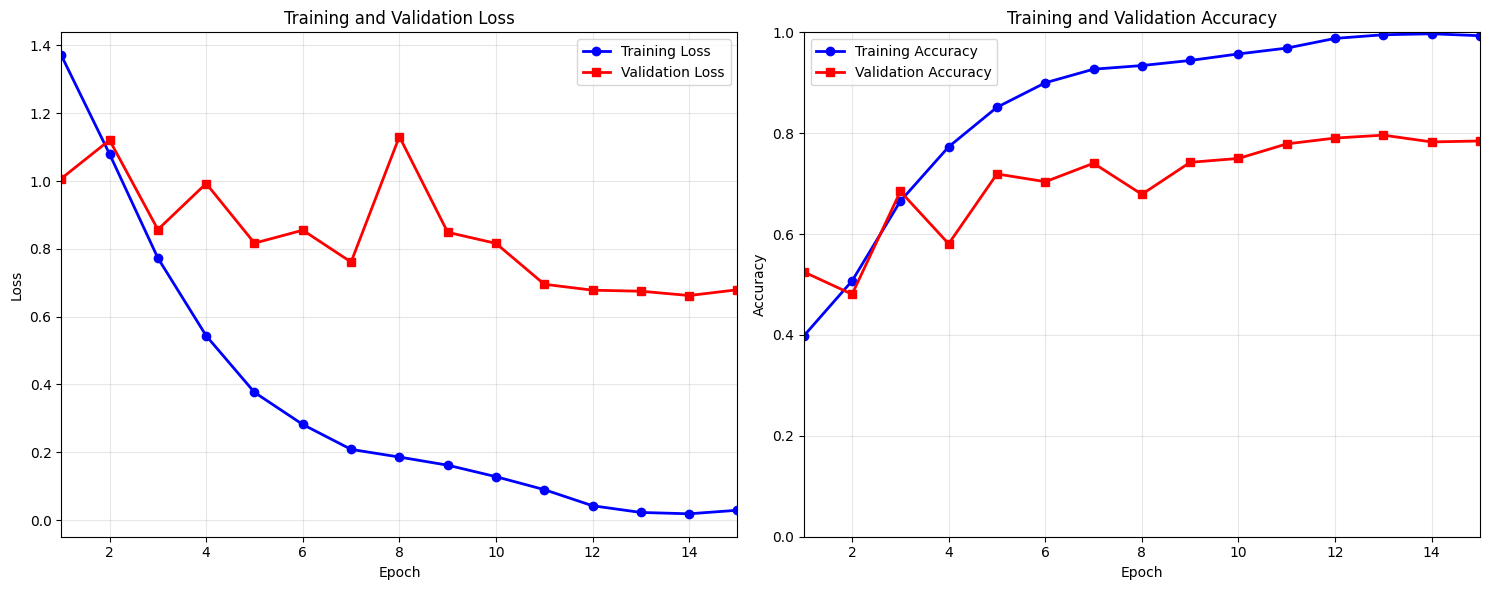

Fold 5 Test Accuracy: 0.7846
Fold 5 Confusion Matrix:
[[ 42  15  24]
 [  4  61  41]
 [ 11  17 305]]

Average Results Across Folds:
Average Test Accuracy: 0.8155
Average Confusion Matrix:
[[ 51.    6.8  23.2]
 [  3.4  60.   42.8]
 [  6.8  13.  313.2]]


In [10]:
label_dict = get_label_dict('Dataset/mias_derived_info.csv', aug_img_dict)
train(img_dict=aug_img_dict, label_dict=label_dict, num_classes=3, num_folds=5, batch_size=32, drop_last=True, num_epochs=15)